# Uniswap and Chainlink Oracle Analysis

In this notebook, I'll be briefly covering:
- how to get oracle feed prices from Chainlink, Uniswap V2, and Uniswap V3
- accuracy of ETH/USDC prices across the three sources
- historical usage of oracles, and who is using these oracles the most

Data is sourced from EDW by tokenflow insights, you can read my writeup on how to work with this data [here](https://twitter.com)

In [1]:
#import our packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

## Oracle Prices

We're going to preprocess data from Uniswap v2/v3 first, since there isn't anything we have to change about Chainlink's data feeds. 

#### Uniswap Calculations 

For both V2 and V3, we can use the respective price accumulator values with some time-weighting to get an average price (explained in their [docs](https://docs.uniswap.org/protocol/V2/concepts/core-concepts/oracles). For V2, this means getting price1cumulative at two timestamps, then subtracting and dividing them. 

In this notebook, you can do this just tx by tx or by setting `floor_min` to some minute value. If you don't care for different TWAP intervals, then leave it as `None`. When I was looking, setting no floor versus setting up to 10 min didn't drastically change results.

*if you're from Uniswap, please add something in the docs in v2 on calculating spot price about needing to divide prices by `2**112`. And for v3, add something about inverting the tick price calculation such that it's `1/1.0001**i)` if it's token 1 you're calculating for. would have saved me some time :P*

In [8]:
# used for TWAP time framing on uniswap data. Set it to <None> if you want the fastest TWAP.
min_floor = None #"5min"

In [9]:
uni_v2 = pd.read_csv(r'oracle_prices/uniswap_v2_price.csv')
uni_v2["datetime"] = pd.to_datetime(uni_v2["TIMESTAMP"])

if min_floor != None:
    uni_v2["minute_floor"] = uni_v2['datetime'].dt.floor(min_floor) #adjust this if you want to have different subsets.
    uni_v2.drop_duplicates(subset=["minute_floor"], keep='last', inplace=True) #keep only last swap results from a block/timestamp, in case of multi-swap
else:
    uni_v2.drop_duplicates(subset=["TIMESTAMP"], keep='last', inplace=True) #keep only last swap results from a block/timestamp, in case of multi-swap
uni_v2 = uni_v2.sort_values(by='datetime', ascending=True)
uni_v2.reset_index(drop=True, inplace=True)

uni_v2["price1Diff"] = uni_v2["CUMULATIVE_LAST"].diff(1) #here I'm taking the difference in prices
uni_v2["price1Diff"] = uni_v2["price1Diff"].div(2**112) #decode UQ112x112 used when storing prices in _update() function
uni_v2["timeDiffSeconds"] = uni_v2["datetime"].diff(1) #here I'm taking the difference in timestamp
uni_v2["timeDiffSeconds"] = uni_v2["timeDiffSeconds"].apply(lambda x: x.total_seconds()) #convert from interval to seconds
uni_v2["uni_v2_ETH_price"] = uni_v2["price1Diff"].div(uni_v2["timeDiffSeconds"]) #divide to get TWAP
uni_v2["uni_v2_ETH_price"] = uni_v2["uni_v2_ETH_price"].apply(lambda x: x * 1e12) #moving decimals

#some tx_hashes in EDW have wrong timestamp rn, so I filter out weird values - it's only a few of them.
uni_v2 = uni_v2[(uni_v2['uni_v2_ETH_price'] > 1000) & (uni_v2['uni_v2_ETH_price'] < 10000)] 
# uni_v2.plot(kind = "line", x = "datetime", y = "uni_v2_ETH_price")

In [10]:
#all of this is basically same as above in v2, just an extra function in the last lambda.
uni_v3_03 = pd.read_csv(r'oracle_prices/uniswapv3_storage_003_0x8ad599c3A0ff1De082011EFDDc58f1908eb6e6D8.csv')
uni_v3_03.dropna(inplace=True)
uni_v3_03["datetime"] = pd.to_datetime(uni_v3_03["TIMESTAMP"])

if min_floor != None:
    uni_v3_03["minute_floor"] = uni_v3_03['datetime'].dt.floor(min_floor) #adjust this if you want to have different subsets.
    uni_v3_03.drop_duplicates(subset=["minute_floor"], keep='last', inplace=True) #keep only last swap results from a block/timestamp, in case of multi-swap
else:
    uni_v3_03.drop_duplicates(subset=["TIMESTAMP"], keep='last', inplace=True)
uni_v3_03.reset_index(drop=True, inplace=True)

uni_v3_03["tickDiff"] = uni_v3_03["TICKCUMULATIVE"].diff(1)
uni_v3_03["timeDiffSeconds"] = uni_v3_03["datetime"].diff(1)
uni_v3_03["timeDiffSeconds"] = uni_v3_03["timeDiffSeconds"].apply(lambda x: x.total_seconds())
uni_v3_03["average_tick"] = uni_v3_03["tickDiff"].div(uni_v3_03["timeDiffSeconds"])
uni_v3_03["uni_v3_ETH_price"] = uni_v3_03["average_tick"].apply(lambda x: 1/(1.0001**x) * 1e12) #inverse of exponential for token1, then move decimals

#filtering for same reason as earlier
uni_v3_03 = uni_v3_03[(uni_v3_03['average_tick'] > 100000) & (uni_v3_03['average_tick'] < 300000)]

#### Chainlink Calculations 

For chainlink I just do some deduplication, that's it.

In [11]:
chainlink = pd.read_csv(r'oracle_prices/chainlink_oracle_price.csv')
chainlink["datetime"] = pd.to_datetime(chainlink['TIMESTAMP'])
chainlink = chainlink[chainlink["ETH_PRICE"] != 0] #for some reason EDW shows some 70 values as 0, maybe a read error?
chainlink.drop_duplicates(subset='TIMESTAMP', keep='last', inplace=True)
chainlink.rename(columns={'ETH_PRICE': 'chainlink_ETH_price'}, inplace=True)

### Putting it together

Let's join all the tables, and do a forward fill for any missing timestamps after outer join.

In [12]:
notionals = ["chainlink_ETH_price", "uni_v2_ETH_price", "uni_v3_ETH_price"] 
comps = ["univ3_chainlink_diff", "univ2_chainlink_diff", "univ2_chainlink_ratio","univ3_chainlink_ratio"]

merged_data = pd.merge(uni_v2[["datetime", "uni_v2_ETH_price"]], uni_v3_03[["datetime", "uni_v3_ETH_price"]],left_on = 'datetime', right_on = 'datetime', how = 'outer')
merged_data = pd.merge(merged_data, chainlink[["datetime", "chainlink_ETH_price"]], left_on = 'datetime', right_on = 'datetime', how = 'outer')
merged_data.sort_values(by = 'datetime', ascending=True, inplace=True)
merged_data = merged_data.ffill() #chainlink ffill is a bit erroneous but good enough for now.

Here, we calculate the notional differences in prices between uniswap and chainlink, as well as a the ratio of prices.

In [13]:
merged_data["univ2_chainlink_diff"] = merged_data["uni_v2_ETH_price"] - merged_data["chainlink_ETH_price"]
merged_data["univ3_chainlink_diff"] = merged_data["uni_v3_ETH_price"] - merged_data["chainlink_ETH_price"]
merged_data["univ2_chainlink_ratio"] = merged_data["uni_v2_ETH_price"].div(merged_data["chainlink_ETH_price"])
merged_data["univ3_chainlink_ratio"] = merged_data["uni_v3_ETH_price"].div(merged_data["chainlink_ETH_price"])

In [14]:
#pivot table to minute just to simplify the number of rows - otherwise you're plotting way too many points. 
merged_data["minute"] = merged_data["datetime"].dt.round('1min')
minute_differences = merged_data.pivot_table(index="minute", values = comps, aggfunc = "mean")
minute_differences.reset_index(inplace=True)

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>], dtype=object)

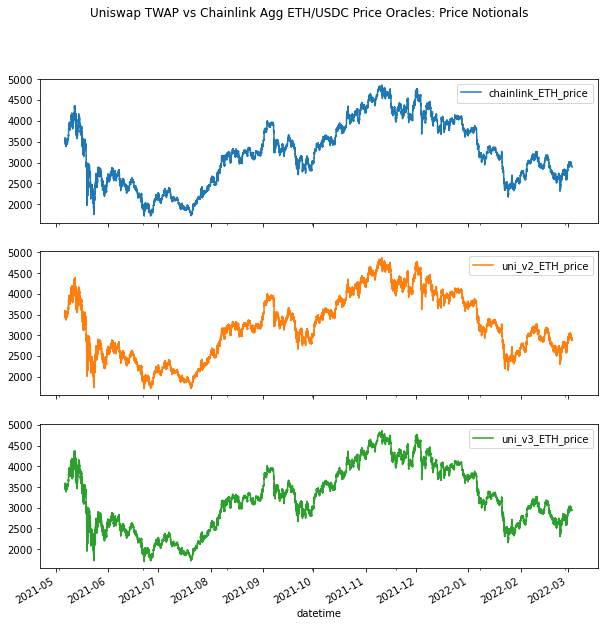

In [16]:
## line plot notionals
merged_data.plot(kind="line", 
                  x = "datetime", 
                  y = notionals,
                  title = "Uniswap TWAP vs Chainlink Agg ETH/USDC Price Oracles: Price Notionals",
                  subplots=True,
                  figsize = (10,10))

array([<AxesSubplot:xlabel='minute'>, <AxesSubplot:xlabel='minute'>,
       <AxesSubplot:xlabel='minute'>, <AxesSubplot:xlabel='minute'>],
      dtype=object)

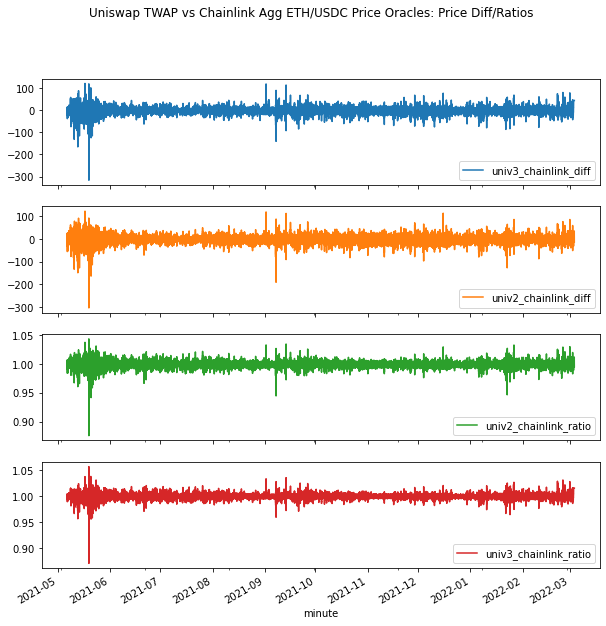

In [17]:
## line plot comps
minute_differences.plot(kind="line", 
                  x = "minute", 
                  y = comps, 
                  subplots = True, 
                  figsize = (10,10),
                  title = "Uniswap TWAP vs Chainlink Agg ETH/USDC Price Oracles: Price Diff/Ratios")

In [18]:
#stacked dfs for seaborn hue stuff (requires typed cloumns)
differences_df = minute_differences[["minute","univ3_chainlink_diff", "univ2_chainlink_diff"]].set_index("minute").stack()
differences_df = differences_df.reset_index()
differences_df.columns = ["minute", "price_source", "price_difference"]

ratio_df = minute_differences[["minute","univ3_chainlink_ratio", "univ2_chainlink_ratio"]].set_index("minute").stack()
ratio_df = ratio_df.reset_index()
ratio_df.columns = ["minute", "price_source", "price_ratio"]

C:\Users\13104\anaconda3\envs\dev\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


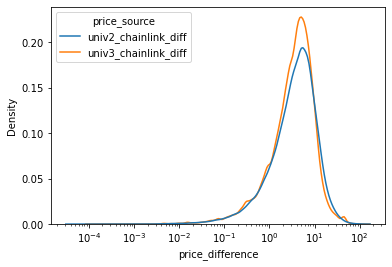

In [19]:
diff_fig = sns.kdeplot(data=differences_df, x="price_difference", hue="price_source", log_scale=True)
#don't worry about the log error.

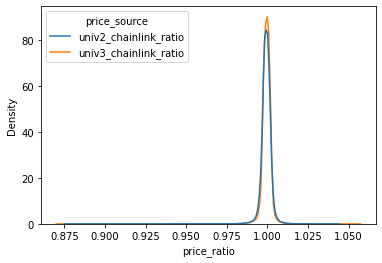

In [20]:
ratio_fig = sns.kdeplot(data=ratio_df, x="price_ratio", hue="price_source", log_scale=False)

### Thoughts before moving on

Overall, uniswap v3 gives a tighter and better TWAP oracle price than uniswap v2. I wouldn't take this as definitive across pairs or time, and there's definitely still a lot of follow up analysis to do. If you want to take a stab at it, here are some research questions to jump off of: 
- role of arb bots
- zooming in on different phases/trends in the time series
- studying liquidity depth at points in time
- trading volume correlation with ratio/diffs at points in time
- different token pairs (two non-stables would be fun)
- different trading paths (i.e. ETH/USDC should be closer to 1 because its in the middle of many paths and is most active by volume)


## Oracle Usage

Let's check out how these oracles are being used over time, in terms of number of calls to the oracle contract each day as well as unique addresses (contracts) which are calling each oracle.

In [2]:
#bring in time series read data for uniswap and chainlink, and then join them
time_univ3 = pd.read_csv(r'oracle_reads/daily_reads_uniswapv3.csv')
time_univ3.columns = ["datetime", "uni_v3_unique_contracts", "uni_v3_total_calls"]
time_univ3["datetime"] = pd.to_datetime(time_univ3['datetime'])

time_chainlink = pd.read_csv(r'oracle_reads/daily_reads_chainlink.csv')
time_chainlink.columns = ["datetime", "chainlink_unique_contracts", "chainlink_total_calls"]
time_chainlink["datetime"] = pd.to_datetime(time_chainlink['datetime'])

merged_time = pd.merge(time_chainlink, time_univ3,left_on = 'datetime', right_on = 'datetime', how = 'outer')

[Text(0, 0.5, '# contract addresses making calls)')]

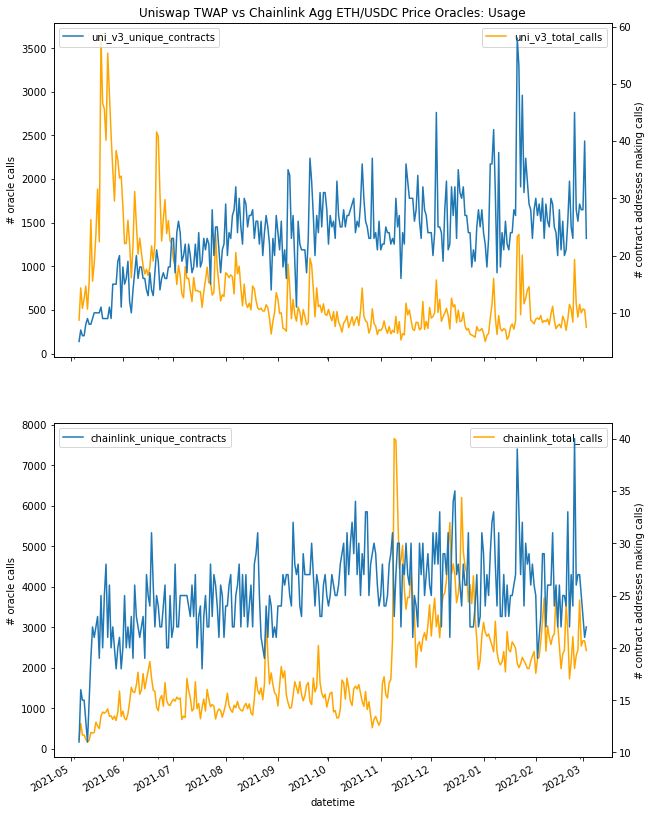

In [3]:
#plot usage/sources with subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,15))
merged_time.plot(kind="line", 
                    x = "datetime", 
                    y = "uni_v3_total_calls",
                    color = 'orange',
                    title = "Uniswap TWAP vs Chainlink Agg ETH/USDC Price Oracles: Usage",
                    ax = ax1)

ax1twin = ax1.twinx()
merged_time.plot(kind="line", 
                    x = "datetime", 
                    y = "uni_v3_unique_contracts",
                    ax = ax1twin)

ax1.set(ylabel="# oracle calls")
ax1twin.set(ylabel="# contract addresses making calls)")

merged_time.plot(kind="line", 
                    x = "datetime", 
                    y = "chainlink_total_calls",
                    color = 'orange',
                    ax = ax2)

ax2twin = ax2.twinx()
merged_time.plot(kind="line", 
                    x = "datetime", 
                    y = "chainlink_unique_contracts",
                    ax = ax2twin)

ax2.set(ylabel="# oracle calls")
ax2twin.set(ylabel="# contract addresses making calls)")

### Top Users (Contracts) that rely on these two oracles

**Uniswap V3 oracle** users include mostly exchanges like 0x and a ton of MEVbots. Uniswap V2 was not included in this analysis because oracle data is not stored in the pair contract.

**For Chainlink data feeds**, the top user by far is ENS - which checks the ETH price during each registration. 

I haven't really dived deeper than the top 10 or 20 addresses, but it would be cool to tie this to an oracle usage guide like Linda's old repo [here](https://github.com/linda-xie/defi-oracles). 

In [5]:
top_univ3 = pd.read_csv(r'oracle_reads/top_reads_uniswapv3.csv')

top_univ3.head(10)

,FROM_ADDRESS,TOTAL_TIMES_QUERIED
0,0xe592427a0aece92de3edee1f18e0157c05861564,104970
1,0xc36442b4a4522e871399cd717abdd847ab11fe88,50763
2,0x0000008cf69d25162321fed9f6789f2a5cade6bc,5703
3,0xfd3dfb524b2da40c8a6d703c62be36b5d8540626,5487
4,0xcd9e13b2f3bfc26cd99989fb849a2751932595c4,5265
5,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,5159
6,0x51399b32cd0186bb32230e24167489f3b2f47870,3248
7,0x8aff5ca996f77487a4f04f1ce905bf3d27455580,2643
8,0xdef1c0ded9bec7f1a1670819833240f027b25eff,2227
9,0x27239549dd40e1d60f5b80b0c4196923745b1fd2,1660


In [6]:
top_chainlink = pd.read_csv(r'oracle_reads/top_reads_chainlink.csv')

top_chainlink.head(10)

,FROM_ADDRESS,TOTAL_TIMES_QUERIED
0,0x63faf46dadc9676745836289404b39136622b821,439181
1,0xa51b83e420c5f82982dc8b7f4514c9bea0b290ee,84069
2,0xb503cd2492b871ef3d6d972777814934011bf29c,11189
3,0xec6f4cd64d28ef32507e2dc399948aae9bbedd7e,10651
4,0x210ac53b27f16e20a9aa7d16260f84693390258f,3055
5,0xe8929afd47064efd36a7fb51da3f8c5eb40c4cb4,3005
6,0xb825e25856bd98b3f2faf2aeb6cb8742b38c4025,2833
7,0x3d619bc03014917d3b27b3b86452346af36e58de,2668
8,0x82e9283e7a64ae1516ef6753dc9d733609c07491,2565
9,0x1ad386d647c216f3fe5a4fc04f6e4cb83e3048cf,2488
